# Вступление

Сердечно-сосудистые заболевания (ССЗ) являются причиной смерти № 1 во всем мире, унося, по оценкам, 17,9 миллиона жизней каждый год, что составляет 31% всех смертей в мире.

Сердечная недостаточность - это распространенное событие, вызванное ССЗ, и этот набор данных содержит 12 признаков, которые могут быть использованы для прогнозирования смертности от сердечной недостаточности:

* age - Возраст пациента, (40, ..., 95) лет
* sex - Пол пациента, мужчина/женщина
* anaemia - Снижение количества эритроцитов или гемоглобина (уровень гематокрита был ниже 36%), да/нет
* diabetes - Наличие у пациента сахарного диабета, да/нет
* smoking - Курящий пациент, да/нет
* creatinine_phosphokinase - Уровень фермента креатинфосфокиназа (КФК) в крови, (23, ..., 7861) мкг/л
* high_blood_pressure - Наличие у пациента гипертонии, да/нет
* ejection_fraction - Процент крови, покидающей сердце при каждом сокращении, (14, ..., 80) %
* platelets - Уровень тромбоцитов в крови, (25.01, ..., 850.00) кровяных пластинок на 1 мкл крови
* serum_creatinine - Уровень креатинина в сыворотке,	(0.50, ..., 9.40) мг/дЛ
* serum_sodium - Уровень натрия в крови, Level of sodium in the blood, (114, ..., 148) ммоль/л
* time - Период наблюдения, (4, ..., 285) дней
* DEATH_EVENT = Смерть пациента в течение периода наблюдения, да/нет

Большинство сердечно-сосудистых заболеваний можно предотвратить, обратившись к поведенческим факторам риска, таким как употребление табака, нездоровое питание и ожирение, гиподинамия и вредное употребление алкоголя, используя общепопуляционную стратегию.

Люди с сердечно-сосудистыми заболеваниями или подверженные высокому риску (из-за наличия одного или нескольких факторов риска, таких как гипертония, диабет, гиперлипидемия) нуждаются в раннем выявлении и лечении, где модель машинного обучения может оказать большую помощь.

# Подготовка

In [1]:
# Устанавливаем все необъодимые библиотеки

!pip install -q --upgrade pip
!pip install -q pycaret
!pip install -q sweetviz
!pip install -q pandas-profiling[notebook]
!pip install -q lofo-importance
!pip install -q tqdm==4.54.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kubernetes 10.1.0 requires pyyaml~=3.12, but you have pyyaml 5.3.1 which is incompatible.
jupyterlab-git 0.10.0 requires nbdime<2.0.0,>=1.1.0, but you have nbdime 2.0.0 which is incompatible.


In [2]:
# Подгружаем все необходимые библиотеки

import os

import numpy as np
import pandas as pd

from lofo import LOFOImportance, Dataset, plot_importance

from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import GenericUnivariateSelect, f_classif, mutual_info_classif, chi2
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score

from pycaret.datasets import get_data
from pycaret.classification import setup, compare_models, create_model, tune_model, plot_model, predict_model, calibrate_model, save_model, interpret_model, get_config, evaluate_model

import sweetviz as sv

from pandas_profiling import ProfileReport

%matplotlib inline

pd.set_option('max_columns', None)

/opt/conda/lib/python3.7/site-packages/lofo/lofo_importance.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# Устанавливаем RANDOM_SEED

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# EDA

In [4]:
# Подгружаем датасет

df = pd.read_csv('../input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv')

Произведем небольшие манипуляции над названиями и порядком фичей для большего удобства.

In [5]:
# Сделаем перестановку фичей для более логичного представления

df = df[['sex', 'age', 
         'smoking', 'diabetes', 'high_blood_pressure',
         'anaemia', 'platelets', 'ejection_fraction',
         'creatinine_phosphokinase', 'serum_creatinine','serum_sodium',
         'time', 'DEATH_EVENT']]

In [6]:
# Переименуем названия фичей

df = df.rename(columns={'smoking':'smk',
                        'diabetes':'dia',
                        'anaemia':'anm',
                        'platelets':'plt',
                        'high_blood_pressure':'hbp',
                        'creatinine_phosphokinase':'cpk',
                        'ejection_fraction':'ejf',
                        'serum_creatinine':'scr',
                        'serum_sodium':'sna',
                        'DEATH_EVENT':'death'})

In [7]:
# Обработаем бинарные фичи

df['sex'] = df['sex'].apply(lambda x: 'Female' if x==0 else 'Male')
df['smk'] = df['smk'].apply(lambda x: 'No' if x==0 else 'Yes')
df['dia'] = df['dia'].apply(lambda x: 'No' if x==0 else 'Yes')
df['anm'] = df['anm'].apply(lambda x: 'No' if x==0 else 'Yes')
df['hbp'] = df['hbp'].apply(lambda x: 'No' if x==0 else 'Yes')
df['death'] = df['death'].apply(lambda x: 'No' if x==0 else 'Yes')

Для EDA анализа датасета я использовал библиотеки [SweetViz](https://github.com/fbdesignpro/sweetviz) и [Pandas Profiling](https://github.com/pandas-profiling/pandas-profiling). Они генерят отчет в формате HTML.

In [8]:
# Формируем отчеты по датасету

my_report = sv.analyze(df)
my_report.show_html()


profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)
profile.to_file("PANDAS_PROFILING_REPORT.html")


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


* Датасет состоит из 299 записей (пациентов).
* Пропущенных значений нет.
* Целевая переменная не сбалансирована (68% vs 32%).
* Количественные переменные:
    * Age: Мы видим, что средний возраст пациентов составляет 60 лет, причем большинство пациентов (<75%) моложе 70 лет и старше 40 лет. Время наблюдения после их сердечной недостаточности также варьируется от 4 дней до 285 дней, в среднем 130 дней.
    * Platelets: Тромбоциты - тип клеток крови, которые отвечают за восстановление поврежденных кровеносных сосудов. У нормального человека количество тромбоцитов составляет 150 000 - 400 000 пластинок/мл крови. В нашем наборе данных 75% пациентов имеют количество тромбоцитов в пределах этого диапазона.
    * Ejection fraction: Фракция выброса это показатель (в %) того, сколько крови откачивается из желудочка при каждом сокращении. У здорового взрослого человека эта фракция составляет 55%, а сердечная недостаточность со сниженной фракцией выброса подразумевает значение < 40%. В нашем наборе данных 75% пациентов имеют это значение < 45%, что ожидаемо, потому что все они являются пациентами с сердечной недостаточностью в первую очередь.
    * Creatinine Phosphokinase: Это фермент, который присутствует в крови и помогает в восстановлении поврежденных тканей. Высокий уровень КФК подразумевает сердечную недостаточность или травму. Нормальные уровни у мужчин составляют 55-170 мкг/л, а у женщин - 30-135 мкг/л. В нашем наборе данных, поскольку все пациенты имели сердечную недостаточность, среднее значение (550 мкг/л) и медиана (250 мкг/л) выше нормы.
    * Serum Creatinine: это продукт отходов, который вырабатывается как часть мышечного метаболизма, особенно во время распада мышц. Этот креатинин фильтруется почками, и его повышенный уровень свидетельствует о плохом сердечном выбросе и возможной почечной недостаточности. Нормальные уровни находятся в диапазоне от 0,84 до 1,21 мг/дл, а в нашем наборе данных среднее и медиана превышают 1,10 мг / дл, что довольно близко к верхней границе нормального диапазона.
    * Serum sodium: это относится к уровню натрия в крови, а высокий уровень > 135 мэкв/л называется гипернатриемией, которая считается типичной для пациентов с сердечной недостаточностью. В нашем наборе данных мы находим, что среднее значение и медиана составляют > 135 мэкв/л.
* Категориальные переменные:
    * Основываясь на статистических данных, мы получаем приблизительное представление о том, что особенности образа жизни почти одинаково распределены между теми, кто умер, и теми, кто выжил. Наибольшая разница в случае высокого кровяного давления, которое, возможно, могло бы оказать большее влияние на выживаемость сердечных больных.
* Корреляции:
    * Количественные переменные:
        * Большинство пациентов, умерших после сердечной недостаточности, имеют более низкую фракцию выброса, чем те, кто выжил. Они также, по-видимому, имеют несколько более высокие уровни сывороточного креатинина и креатинфосфокиназы. Их возраст, как правило, больше 80 лет.
        * Между признаками нет сильных корреляций, за ислючением одного случая. Переменная time (период наблюдения) будет исключена из дальнейшего анализа, т.к. она имеет очень сильную корреляцию с целевой переменной.
    * Категориальыне переменные:
        * Большое количество пациентов не курили, не страдали анемией, от высокого кровяного давления или диабета.
        * Было очень мало пациентов, которые имели все четыре особенности.
        * Многие из выживших были либо курильщиками, либо диабетиками.
        * Большинство умерших не имели никаких особенностей.
        * Многие из умерших также страдали анемией и диабетом.

In [9]:
df.drop(['time'], axis=1, inplace=True)

# Feature Selection Part 1. LOFO

Отбор признаков будем проводить в два этапа.

На первом этапе используем библиотеку [LOFO (Leave One Feature Out)](https://github.com/aerdem4/lofo-importance). Она вычисляет важность набора признаков на основе выбранной метрики для модели выбора, итеративно удаляя каждый признак из набора и оценивая производительность модели с помощью схемы проверки выбора, основанной на выбранной метрике.

Если модель не передается в качестве аргумента LofoImportance, она будет запускать LightGBM в качестве модели по умолчанию.

Пока будем использовать метрику ROC AUC.

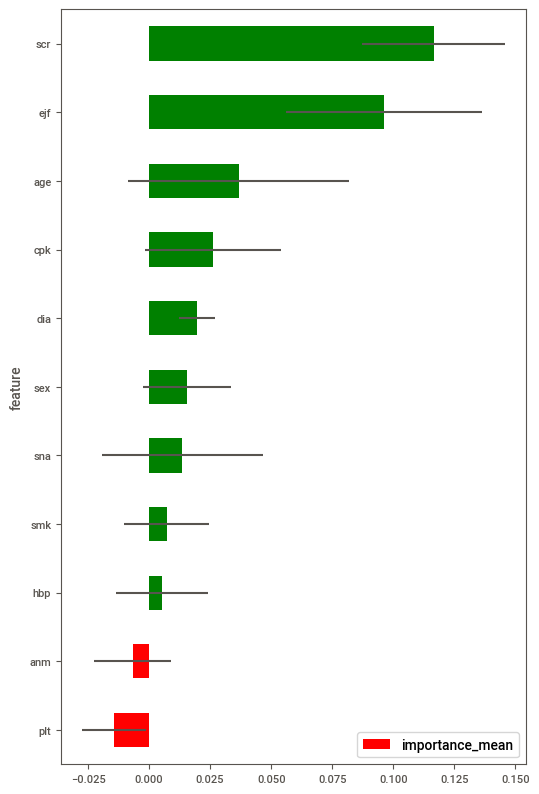

In [10]:
# Зададим нашу целевую переменную и признаки
dataset = Dataset(df=df, target='death', features=[col for col in df.columns if col != 'death'])

# Зададил схему валидации
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Зададим метрику, по которой будем определять качество модели
lofo_imp = LOFOImportance(dataset, cv=cv, scoring="roc_auc")

# Получим среднее и значение и стандартное отклонение показателя важности
importance_df = lofo_imp.get_importance()

# Построим на графике показатели важности
plot_importance(importance_df, figsize=(6,10))

Мы видим, что самый значительный вклад в изменение метрики вносят признаки: Serum Creatinine, Ejection Fraction, Age. Зафиксируем это и перейдем ко второй части.

# Feature Selection Part 2

In [11]:
# Разделим датасет на X (фичи) и y (целевую переменную)

y = df['death'].values
X = df.drop(['death'], axis=1)

Попробуем провести отбор фичей с помощью GenericUnivariateSelect из sklearn, ориентируясь на следующую схему.

![](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/11/How-to-Choose-Feature-Selection-Methods-For-Machine-Learning.png)

Сначала разберемся с количественными переменными. Посчитаем параметр ANOVA F-value для всех количественных переменных.

In [12]:
selection_num = GenericUnivariateSelect(f_classif, mode='k_best', param=3)
X_num = selection_num.fit_transform(X[['age', 'plt', 'ejf', 'cpk', 'scr', 'sna']], y)
display(selection_num.scores_)
display(X_num.shape)

array([20.43594646,  0.71888045, 23.09406305,  1.17325872, 28.15849226,
       11.76533129])

(299, 3)

В итоге видим, что самые высокие значения ANOVA F-value имеют следующие признаки: Age, Ejection Fraction, Serum Creatinine.

Теперь перейдем к категориальным признакам. Посчитаем параметр mutual_info_classif для категориальных переменных.

In [13]:
# Закодируем категориальные признаки с помощью OrdinalEncoder

def prepare_inputs(X):
    oe = OrdinalEncoder()
    oe.fit(X)
    X_enc = oe.transform(X)
    return X_enc

X_cat = prepare_inputs(X[['sex', 'smk', 'dia', 'hbp', 'anm']])

In [14]:
selection_cat = GenericUnivariateSelect(mutual_info_classif, mode='k_best', param=3)
X_cat = selection_cat.fit_transform(X_cat, y)
display(selection_cat.scores_)
display(X_cat.shape)

array([0.        , 0.        , 0.00225588, 0.04573215, 0.04485149])

(299, 3)

Очевидно, что самые высокие значения ANOVA F-value имеют следующие признаки: Heart Blood Pressure, Anemia.

Суммировав первую и вторую часть отбора признаков делаем вывод, что в датасете требуется оставить следующие признаки + целевую переменную:
Age, Ejection Fraction, Serum Creatinine, Heart Blood Pressure, Anemia, Death.

In [15]:
df = df[['age', 'ejf', 'scr', 'hbp', 'anm', 'death']]

# PyCaret

Для построения и модели мы будем использовать библиотеку PyCaret. Это библиотека машинного обучения с открытым исходным кодом на Python для обучения и развертывания моделей с учителем и без учителя в low-code среде.

По сравнению с другими открытыми библиотеками машинного обучения, PyCaret – это low-code альтернатива, которая поможет заменить сотни строк кода всего парой слов. Это позволяет значительно сократить время создания и оптимизации модели.

PyCaret проста и удобна в использовании. Все операции, выполняемые PyCaret, последовательно сохраняются в пайплайне полностью готовом для развертывания. Будь то добавление пропущенных значений, преобразование категориальных данных, инженерия признаков или оптимизация гиперпараметров, PyCaret сможет все это автоматизировать.

In [16]:
# Откопируем датасет
df_copy = df.copy()

In [17]:
# Создаем конфгурацию для движка сравнения моделей МО
grid = setup(data=df_copy, target=df_copy.columns[-1], train_size=0.90, preprocess=True, 
             html=False, silent=True, verbose=False, session_id=42, fix_imbalance=True, 
             categorical_features=['hbp', 'anm'],
             numeric_features=['age', 'ejf', 'scr'],
#             categorical_features=['hbp', 'anm'],
#             numeric_features=['age', 'ejf', 'scr'],
#             pca=True, pca_method='linear', pca_components=5,
#             normalize=True, normalize_method='robust', transformation=True, transformation_method='quantile',
            )

Выбор метрики.

Проанализировав несколько статей по схожим проектам МО (например https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7), я пришел к выводу, что правильнее всего будет использовать метрику MCC (Matthews correlation coefficient) как основную. Так как она является более надежным статистическим показателем, которая выдает высокое значение только в том случае, если прогноз получил хорошие результаты во всех четырех категориях матрицы путаницы (истинные положительные, ложные отрицательные, истинные отрицательные и ложные положительные), ***пропорционально как размеру положительных элементов, так и размеру отрицательных элементов в наборе данных***. Метрику AUC будем использовать как дополнительное подтверждение.

Сравним производительность разных моделей МО на 5-ти фолдовой кросс-валидации.

In [18]:
# Запустим задачу сравнения производительности множества моделей МО
best = compare_models(sort='MCC', fold=5, n_select=1)
print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7208,0.7617,0.689,0.5491,0.6064,0.3964,0.4066,0.264


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7208,0.7617,0.6890,0.5491,0.6064,0.3964,0.4066,0.264
knn,K Neighbors Classifier,0.6584,0.7037,0.5596,0.4748,0.5101,0.2528,0.2564,0.096


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.7695,0.7782,0.5596,0.6525,0.6012,0.4409,0.4442,0.018
lr,Logistic Regression,0.7208,0.7617,0.6890,0.5491,0.6064,0.3964,0.4066,0.264
knn,K Neighbors Classifier,0.6584,0.7037,0.5596,0.4748,0.5101,0.2528,0.2564,0.096


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.7695,0.7782,0.5596,0.6525,0.6012,0.4409,0.4442,0.018
lr,Logistic Regression,0.7208,0.7617,0.6890,0.5491,0.6064,0.3964,0.4066,0.264
dt,Decision Tree Classifier,0.7251,0.6830,0.5713,0.5565,0.5609,0.3613,0.3638,0.020
knn,K Neighbors Classifier,0.6584,0.7037,0.5596,0.4748,0.5101,0.2528,0.2564,0.096


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.7695,0.7782,0.5596,0.6525,0.6012,0.4409,0.4442,0.018
lr,Logistic Regression,0.7208,0.7617,0.6890,0.5491,0.6064,0.3964,0.4066,0.264
svm,SVM - Linear Kernel,0.6769,0.0000,0.7353,0.5373,0.5961,0.3589,0.3930,0.018
dt,Decision Tree Classifier,0.7251,0.6830,0.5713,0.5565,0.5609,0.3613,0.3638,0.020
knn,K Neighbors Classifier,0.6584,0.7037,0.5596,0.4748,0.5101,0.2528,0.2564,0.096


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.7695,0.7782,0.5596,0.6525,0.6012,0.4409,0.4442,0.018
ridge,Ridge Classifier,0.7319,0.0000,0.7007,0.5625,0.6197,0.4183,0.4281,0.018
lr,Logistic Regression,0.7208,0.7617,0.6890,0.5491,0.6064,0.3964,0.4066,0.264
svm,SVM - Linear Kernel,0.6769,0.0000,0.7353,0.5373,0.5961,0.3589,0.3930,0.018
dt,Decision Tree Classifier,0.7251,0.6830,0.5713,0.5565,0.5609,0.3613,0.3638,0.020
knn,K Neighbors Classifier,0.6584,0.7037,0.5596,0.4748,0.5101,0.2528,0.2564,0.096


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7659,0.7890,0.6301,0.6279,0.6265,0.4563,0.4583,0.394
nb,Naive Bayes,0.7695,0.7782,0.5596,0.6525,0.6012,0.4409,0.4442,0.018
ridge,Ridge Classifier,0.7319,0.0000,0.7007,0.5625,0.6197,0.4183,0.4281,0.018
lr,Logistic Regression,0.7208,0.7617,0.6890,0.5491,0.6064,0.3964,0.4066,0.264
svm,SVM - Linear Kernel,0.6769,0.0000,0.7353,0.5373,0.5961,0.3589,0.3930,0.018
dt,Decision Tree Classifier,0.7251,0.6830,0.5713,0.5565,0.5609,0.3613,0.3638,0.020
knn,K Neighbors Classifier,0.6584,0.7037,0.5596,0.4748,0.5101,0.2528,0.2564,0.096


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7659,0.7890,0.6301,0.6279,0.6265,0.4563,0.4583,0.394
nb,Naive Bayes,0.7695,0.7782,0.5596,0.6525,0.6012,0.4409,0.4442,0.018
ridge,Ridge Classifier,0.7319,0.0000,0.7007,0.5625,0.6197,0.4183,0.4281,0.018
lr,Logistic Regression,0.7208,0.7617,0.6890,0.5491,0.6064,0.3964,0.4066,0.264
qda,Quadratic Discriminant Analysis,0.7474,0.7620,0.5596,0.6062,0.5808,0.4005,0.4020,0.022
svm,SVM - Linear Kernel,0.6769,0.0000,0.7353,0.5373,0.5961,0.3589,0.3930,0.018
dt,Decision Tree Classifier,0.7251,0.6830,0.5713,0.5565,0.5609,0.3613,0.3638,0.020
knn,K Neighbors Classifier,0.6584,0.7037,0.5596,0.4748,0.5101,0.2528,0.2564,0.096


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7659,0.7890,0.6301,0.6279,0.6265,0.4563,0.4583,0.394
nb,Naive Bayes,0.7695,0.7782,0.5596,0.6525,0.6012,0.4409,0.4442,0.018
ridge,Ridge Classifier,0.7319,0.0000,0.7007,0.5625,0.6197,0.4183,0.4281,0.018
lr,Logistic Regression,0.7208,0.7617,0.6890,0.5491,0.6064,0.3964,0.4066,0.264
qda,Quadratic Discriminant Analysis,0.7474,0.7620,0.5596,0.6062,0.5808,0.4005,0.4020,0.022
svm,SVM - Linear Kernel,0.6769,0.0000,0.7353,0.5373,0.5961,0.3589,0.3930,0.018
dt,Decision Tree Classifier,0.7251,0.6830,0.5713,0.5565,0.5609,0.3613,0.3638,0.020
ada,Ada Boost Classifier,0.7288,0.7491,0.5485,0.5624,0.5514,0.3584,0.3611,0.066
knn,K Neighbors Classifier,0.6584,0.7037,0.5596,0.4748,0.5101,0.2528,0.2564,0.096


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7659,0.7890,0.6301,0.6279,0.6265,0.4563,0.4583,0.394
nb,Naive Bayes,0.7695,0.7782,0.5596,0.6525,0.6012,0.4409,0.4442,0.018
ridge,Ridge Classifier,0.7319,0.0000,0.7007,0.5625,0.6197,0.4183,0.4281,0.018
lr,Logistic Regression,0.7208,0.7617,0.6890,0.5491,0.6064,0.3964,0.4066,0.264
gbc,Gradient Boosting Classifier,0.7472,0.7746,0.5706,0.6033,0.5837,0.4028,0.4051,0.058
qda,Quadratic Discriminant Analysis,0.7474,0.7620,0.5596,0.6062,0.5808,0.4005,0.4020,0.022
svm,SVM - Linear Kernel,0.6769,0.0000,0.7353,0.5373,0.5961,0.3589,0.3930,0.018
dt,Decision Tree Classifier,0.7251,0.6830,0.5713,0.5565,0.5609,0.3613,0.3638,0.020
ada,Ada Boost Classifier,0.7288,0.7491,0.5485,0.5624,0.5514,0.3584,0.3611,0.066
knn,K Neighbors Classifier,0.6584,0.7037,0.5596,0.4748,0.5101,0.2528,0.2564,0.096


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7659,0.7890,0.6301,0.6279,0.6265,0.4563,0.4583,0.394
nb,Naive Bayes,0.7695,0.7782,0.5596,0.6525,0.6012,0.4409,0.4442,0.018
ridge,Ridge Classifier,0.7319,0.0000,0.7007,0.5625,0.6197,0.4183,0.4281,0.018
lda,Linear Discriminant Analysis,0.7319,0.7578,0.7007,0.5625,0.6197,0.4183,0.4281,0.016
lr,Logistic Regression,0.7208,0.7617,0.6890,0.5491,0.6064,0.3964,0.4066,0.264
gbc,Gradient Boosting Classifier,0.7472,0.7746,0.5706,0.6033,0.5837,0.4028,0.4051,0.058
qda,Quadratic Discriminant Analysis,0.7474,0.7620,0.5596,0.6062,0.5808,0.4005,0.4020,0.022
svm,SVM - Linear Kernel,0.6769,0.0000,0.7353,0.5373,0.5961,0.3589,0.3930,0.018
dt,Decision Tree Classifier,0.7251,0.6830,0.5713,0.5565,0.5609,0.3613,0.3638,0.020
ada,Ada Boost Classifier,0.7288,0.7491,0.5485,0.5624,0.5514,0.3584,0.3611,0.066


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7659,0.7890,0.6301,0.6279,0.6265,0.4563,0.4583,0.394
nb,Naive Bayes,0.7695,0.7782,0.5596,0.6525,0.6012,0.4409,0.4442,0.018
ridge,Ridge Classifier,0.7319,0.0000,0.7007,0.5625,0.6197,0.4183,0.4281,0.018
lda,Linear Discriminant Analysis,0.7319,0.7578,0.7007,0.5625,0.6197,0.4183,0.4281,0.016
lr,Logistic Regression,0.7208,0.7617,0.6890,0.5491,0.6064,0.3964,0.4066,0.264
gbc,Gradient Boosting Classifier,0.7472,0.7746,0.5706,0.6033,0.5837,0.4028,0.4051,0.058
qda,Quadratic Discriminant Analysis,0.7474,0.7620,0.5596,0.6062,0.5808,0.4005,0.4020,0.022
svm,SVM - Linear Kernel,0.6769,0.0000,0.7353,0.5373,0.5961,0.3589,0.3930,0.018
dt,Decision Tree Classifier,0.7251,0.6830,0.5713,0.5565,0.5609,0.3613,0.3638,0.020
ada,Ada Boost Classifier,0.7288,0.7491,0.5485,0.5624,0.5514,0.3584,0.3611,0.066


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7659,0.7890,0.6301,0.6279,0.6265,0.4563,0.4583,0.394
nb,Naive Bayes,0.7695,0.7782,0.5596,0.6525,0.6012,0.4409,0.4442,0.018
ridge,Ridge Classifier,0.7319,0.0000,0.7007,0.5625,0.6197,0.4183,0.4281,0.018
lda,Linear Discriminant Analysis,0.7319,0.7578,0.7007,0.5625,0.6197,0.4183,0.4281,0.016
xgboost,Extreme Gradient Boosting,0.7398,0.7493,0.6184,0.5816,0.5984,0.4064,0.4076,0.980
lr,Logistic Regression,0.7208,0.7617,0.6890,0.5491,0.6064,0.3964,0.4066,0.264
gbc,Gradient Boosting Classifier,0.7472,0.7746,0.5706,0.6033,0.5837,0.4028,0.4051,0.058
qda,Quadratic Discriminant Analysis,0.7474,0.7620,0.5596,0.6062,0.5808,0.4005,0.4020,0.022
svm,SVM - Linear Kernel,0.6769,0.0000,0.7353,0.5373,0.5961,0.3589,0.3930,0.018
dt,Decision Tree Classifier,0.7251,0.6830,0.5713,0.5565,0.5609,0.3613,0.3638,0.020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7659,0.7890,0.6301,0.6279,0.6265,0.4563,0.4583,0.394
nb,Naive Bayes,0.7695,0.7782,0.5596,0.6525,0.6012,0.4409,0.4442,0.018
ridge,Ridge Classifier,0.7319,0.0000,0.7007,0.5625,0.6197,0.4183,0.4281,0.018
lda,Linear Discriminant Analysis,0.7319,0.7578,0.7007,0.5625,0.6197,0.4183,0.4281,0.016
lightgbm,Light Gradient Boosting Machine,0.7509,0.7550,0.6066,0.5996,0.6020,0.4209,0.4218,0.404
xgboost,Extreme Gradient Boosting,0.7398,0.7493,0.6184,0.5816,0.5984,0.4064,0.4076,0.980
lr,Logistic Regression,0.7208,0.7617,0.6890,0.5491,0.6064,0.3964,0.4066,0.264
gbc,Gradient Boosting Classifier,0.7472,0.7746,0.5706,0.6033,0.5837,0.4028,0.4051,0.058
qda,Quadratic Discriminant Analysis,0.7474,0.7620,0.5596,0.6062,0.5808,0.4005,0.4020,0.022
svm,SVM - Linear Kernel,0.6769,0.0000,0.7353,0.5373,0.5961,0.3589,0.3930,0.018


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7659,0.7890,0.6301,0.6279,0.6265,0.4563,0.4583,0.394
nb,Naive Bayes,0.7695,0.7782,0.5596,0.6525,0.6012,0.4409,0.4442,0.018
ridge,Ridge Classifier,0.7319,0.0000,0.7007,0.5625,0.6197,0.4183,0.4281,0.018
lda,Linear Discriminant Analysis,0.7319,0.7578,0.7007,0.5625,0.6197,0.4183,0.4281,0.016
lightgbm,Light Gradient Boosting Machine,0.7509,0.7550,0.6066,0.5996,0.6020,0.4209,0.4218,0.404
xgboost,Extreme Gradient Boosting,0.7398,0.7493,0.6184,0.5816,0.5984,0.4064,0.4076,0.980
lr,Logistic Regression,0.7208,0.7617,0.6890,0.5491,0.6064,0.3964,0.4066,0.264
gbc,Gradient Boosting Classifier,0.7472,0.7746,0.5706,0.6033,0.5837,0.4028,0.4051,0.058
qda,Quadratic Discriminant Analysis,0.7474,0.7620,0.5596,0.6062,0.5808,0.4005,0.4020,0.022
svm,SVM - Linear Kernel,0.6769,0.0000,0.7353,0.5373,0.5961,0.3589,0.3930,0.018


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7659,0.7890,0.6301,0.6279,0.6265,0.4563,0.4583,0.394
nb,Naive Bayes,0.7695,0.7782,0.5596,0.6525,0.6012,0.4409,0.4442,0.018
ridge,Ridge Classifier,0.7319,0.0000,0.7007,0.5625,0.6197,0.4183,0.4281,0.018
lda,Linear Discriminant Analysis,0.7319,0.7578,0.7007,0.5625,0.6197,0.4183,0.4281,0.016
lightgbm,Light Gradient Boosting Machine,0.7509,0.7550,0.6066,0.5996,0.6020,0.4209,0.4218,0.404
xgboost,Extreme Gradient Boosting,0.7398,0.7493,0.6184,0.5816,0.5984,0.4064,0.4076,0.980
lr,Logistic Regression,0.7208,0.7617,0.6890,0.5491,0.6064,0.3964,0.4066,0.264
gbc,Gradient Boosting Classifier,0.7472,0.7746,0.5706,0.6033,0.5837,0.4028,0.4051,0.058
qda,Quadratic Discriminant Analysis,0.7474,0.7620,0.5596,0.6062,0.5808,0.4005,0.4020,0.022
svm,SVM - Linear Kernel,0.6769,0.0000,0.7353,0.5373,0.5961,0.3589,0.3930,0.018


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


В результате видим, что максимальное значение метрики  MCC (как впрочем и AUC) достигнуто моделью Random Forest Classifier. Ее мы и выберем для дальнейшего изучения и оптимизации.

Создаем модель на основе Random Forest Classifier и 5-ти фолдовой кросс-валидации.

In [19]:
# Создадим модель на основе лучшей по результатам сравнения
clf = create_model('rf', fold=5)
print(clf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7593,0.8227,0.7059,0.6000,0.6486,0.4674,0.4709
1,0.7593,0.7774,0.5882,0.6250,0.6061,0.4330,0.4334
2,0.7222,0.7472,0.5882,0.5556,0.5714,0.3662,0.3665
3,0.7963,0.8315,0.7059,0.6667,0.6857,0.5352,0.5357
4,0.7925,0.7660,0.5625,0.6923,0.6207,0.4799,0.4848
Mean,0.7659,0.7890,0.6301,0.6279,0.6265,0.4563,0.4583
SD,0.0269,0.0327,0.0625,0.0483,0.0387,0.0558,0.0564


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


Визуально оценим производительность модели. В этом нам поможем дашборд PyCaret, который создается с помощью команды evaluate_model.

In [20]:
evaluate_model(clf)

,Parameters
bootstrap,True
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,None
max_features,auto
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_impurity_split,None


Теперь проведем тюнинг модели в автоматическом режиме (метрика - MCC (среднее значение + стандартное отклонение), 5-ти фолдовая кросс-валидация)

In [21]:
tuned = tune_model(clf, optimize='mcc', fold=5)
print(tuned)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.7s finished


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7593,0.8283,0.6471,0.6111,0.6286,0.4507,0.4511
1,0.7407,0.7870,0.7059,0.5714,0.6316,0.4350,0.4408
2,0.7593,0.7981,0.6471,0.6111,0.6286,0.4507,0.4511
3,0.8333,0.8140,0.6471,0.7857,0.7097,0.5943,0.5998
4,0.7358,0.7297,0.6250,0.5556,0.5882,0.3948,0.3963
Mean,0.7657,0.7914,0.6544,0.6270,0.6373,0.4651,0.4678
SD,0.0351,0.0339,0.0271,0.0823,0.0396,0.0678,0.0690


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={},
                       criterion='gini', max_depth=9, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=120,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [22]:
evaluate_model(tuned)

,Parameters
bootstrap,True
ccp_alpha,0.0
class_weight,{}
criterion,gini
max_depth,9
max_features,sqrt
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0
min_impurity_split,None


После тюнинга мы достигли небольшого улучшения по MCC и AUC c таким же небольшим увеличением стандартного отклонения от среднего значения.

Далее откалибруем модель. При выполнении классификационных экспериментов часто требуется предсказать не только метки классов, но и получить вероятность предсказания. Эта вероятность дает нам некоторую уверенность. Хорошо откалиброванные классификаторы - это вероятностные классификаторы, для которых выход вероятности может быть непосредственно интерпретирован как уровень достоверности.

In [23]:
calibrated = calibrate_model(tuned, fold=5)
print(calibrated)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7963,0.8188,0.6471,0.6875,0.6667,0.5202,0.5207
1,0.7593,0.7536,0.7647,0.5909,0.6667,0.4831,0.4929
2,0.7222,0.7981,0.5294,0.5625,0.5455,0.3457,0.3460
3,0.7963,0.8124,0.6471,0.6875,0.6667,0.5202,0.5207
4,0.7736,0.7179,0.6250,0.6250,0.6250,0.4628,0.4628
Mean,0.7695,0.7801,0.6426,0.6307,0.6341,0.4664,0.4686
SD,0.0275,0.0386,0.0749,0.0504,0.0472,0.0643,0.0649


CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight={},
                                                             criterion='gini',
                                                             max_depth=9,
                                                             max_features='sqrt',
                                                             max_leaf_nodes=None,
                                                             max_samples=None,
                                                             min_impurity_decrease=0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=6,
                                                             min_samples_split=5,
                                      

In [24]:
evaluate_model(calibrated)

,Parameters
base_estimator,"RandomForestClassifier(bootstrap=True, ccp_alp..."
cv,"StratifiedKFold(n_splits=5, random_state=42, s..."
method,sigmoid


После выполнения калибровки мы получили слегка более правильную калибровочную кривую, а также уменьшение стандартного отклонения в обеих метриках.

Предскажем значения целевой переменной на отложенной 10%-ой выборке с помощью тюнингованной и откалиброванной моделей.

In [25]:
predict_model(tuned)
predict_model(calibrated)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.6333,0.6782,0.5,0.5455,0.5217,0.2254,0.2259


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.6667,0.706,0.5,0.6,0.5455,0.2857,0.2887


,age,ejf,scr,hbp_No,anm_No,death,Label,Score
0,70.0,40.0,2.7,1.0,1.0,No,Yes,0.7379
1,50.0,35.0,0.9,1.0,0.0,No,No,0.8430
2,45.0,30.0,1.1,1.0,1.0,Yes,No,0.8569
3,80.0,35.0,9.4,0.0,0.0,Yes,Yes,0.8610
4,42.0,40.0,1.2,1.0,1.0,No,No,0.9151
5,50.0,30.0,0.7,1.0,0.0,No,No,0.8008
6,60.0,25.0,1.7,1.0,0.0,Yes,Yes,0.8563
7,45.0,35.0,1.3,1.0,1.0,No,No,0.8864
8,90.0,40.0,2.1,0.0,0.0,Yes,Yes,0.8845
9,50.0,20.0,0.8,1.0,0.0,No,No,0.5050


In [26]:
save_model(tuned, model_name = 'rds_diploma_100121')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['hbp', 'anm'],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['age', 'ejf', 'scr'],
                                       target='death', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight={}, criterion='gini',
                                         max_depth=9, max_features='sqrt',
                                         max_leaf_nodes=None, max_samples=None,
  